In [1]:
# In addition to numpy, pytorch, and other standard libraries, you will need the following
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


The code below will automatically download and load the dataset. The training and validation split can be accessed with `squad_dataset['train']` and `squad_dataset['validation']` respectively.

In [2]:
from datasets import load_dataset
squad_dataset = load_dataset("squad")

####################################################################################
print("Train/validation split:", len(squad_dataset['train']), "/", len(squad_dataset['validation']), "samples")

print("-----Train Data-----")
train_example = squad_dataset['train'][0]
print("Sample id:", train_example['id'])
print("Context:", train_example['context'])
print("Question:", train_example['question'])
print("Answer:", train_example['answers']['text'][0])

print("-----Validation Data-----")
valid_example = squad_dataset['validation'][0]
print("Sample id:", valid_example['id'])
print("Context:", valid_example['context'])
print("Question:", valid_example['question'])
print("Answer:", valid_example['answers']['text'][0])
####################################################################################

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Train/validation split: 87599 / 10570 samples
-----Train Data-----
Sample id: 5733be284776f41900661182
Context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answer: Saint Bernadette Soubirous
-----Validation Data-----
Sample id: 56be4db0acb8001400a502ec
Context: Supe

In this part, we will extend the GPT2 model to produce answers from the context based on the questions. To make use of the pre-trained GPT2 model, we will treat it as a feature extractor to compute token-wise feature vectors and add additional MLP layers to process the features for the QA task. These additional task-specific layers are sometimes called **"adapters"**.

In [3]:
import torch
import torch.nn as nn
from transformers import GPT2TokenizerFast, GPT2Model

class GPT2QuestionAnswering(nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
        self.gpt2 = GPT2Model.from_pretrained('gpt2')

        ####################################################################################
        hidden_size = self.gpt2.config.hidden_size  # Hidden size of the GPT2 model

        # Add additional layers for predicting the location of the answer
        self.start_classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
        )
        self.end_classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
        )
        ####################################################################################

    def forward(self, question, context, answer=None):
        inputs = self.tokenizer(question, context, return_tensors='pt', return_offsets_mapping=True)
        input_ids = inputs.input_ids[:,:self.gpt2.config.n_positions]
        attention_mask = inputs.attention_mask[:,:self.gpt2.config.n_positions]
        if torch.cuda.is_available:
            input_ids = input_ids.cuda()
            attention_mask = attention_mask.cuda()
        features = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)['last_hidden_state']

        ####################################################################################
        start_logits = self.start_classifier(features).squeeze(-1)
        end_logits = self.end_classifier(features).squeeze(-1)
        ####################################################################################

        if self.training:
            ####################################################################################
            loss = self.loss(start_logits, end_logits, inputs.offset_mapping, answer)
            return loss
            ####################################################################################
        else:
            ####################################################################################
            start_index = torch.argmax(start_logits)
            end_index = torch.argmax(end_logits)
            answer_start_index = inputs.offset_mapping[0, start_index][0].item()
            answer_end_index = inputs.offset_mapping[0, end_index][1].item()
            ####################################################################################
            return self.tokenizer.decode(inputs.input_ids[0, answer_start_index : answer_end_index + 1]).strip()


    ####################################################################################
    def loss(self, start_logits, end_logits, offset_mapping, answer):
        # Compute the loss based on the answers
        # Tip1: If you choose the classification approach, then you need the start and end locations
        #       of the answer within the **tokenized** input as your classification target.
        #       You may need to use inputs.offset_mapping from the input tokenization.
        #       See https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizerFast.__call__.return_offsets_mapping
        # Tip2: If you choose the regression approach, then you can use answer['answer_start']
        #       and length of the answer as your regression target.
        start_positions = answer['answer_start']
        end_positions = [start + len(answer['text'][0]) for start in start_positions]

        # print(start_positions)
        # print(end_positions)

        start_targets = torch.zeros_like(start_logits)
        end_targets = torch.zeros_like(end_logits)

        for start, end in zip(start_positions, end_positions):
            closestEndOffset = len(offset_mapping[0])
            closestStartOffset = len(offset_mapping[0])
            for idx, offset in enumerate(offset_mapping[0]):
              if abs(offset[0] - start) < closestStartOffset:
                start_offsets = idx
                closestStartOffset = abs(offset[0] - start)
              if abs(offset[1] - end) < closestEndOffset:
                end_offsets = idx
                closestEndOffset = abs(offset[1] - end)

              if (closestStartOffset <= 1 and closestEndOffset <= 1):
                break

            start_targets[0, start_offsets] = 1
            end_targets[0, end_offsets] = 1

        start_loss = nn.BCEWithLogitsLoss()(start_logits, start_targets)
        end_loss = nn.BCEWithLogitsLoss()(end_logits, end_targets)

        total_loss = start_loss + end_loss
        return total_loss
    ####################################################################################

We can evaluate the pre-trained model's performance on the validation split. Since the model has not been adapted to the question-answering task yet, and additional untrained layers have been added, we expect the model to perform poorly.

In question-answering task, we use two evaluation metrics:
* **Exact match**: the percentage of predictions that match the ground truth answer exactly
* **F1 score**: the average overlap (in terms of tokens) between the prediction and ground truth answer

Higher values are better for both metrics. For reference, humans can achieve 77.0% exact match and 86.8% F1 score, while SOTA method achieves 90% exact match and over 95% F1 score.

In [4]:
def evaluate(model, dataset, metric):
    from tqdm.autonotebook import tqdm
    model = model.eval()
    preds = []
    for idx, data in enumerate(tqdm(dataset['validation'])):
        preds.append(dict(id=data['id'], prediction_text=model(data['question'], data['context'], data['answers'])))
    references = [dict(answers=data['answers'], id=data['id']) for data in dataset['validation']]
    return metric.compute(predictions=preds, references=references)

In [5]:
from datasets import load_metric

squad_metric = load_metric('squad')
model = GPT2QuestionAnswering()
if torch.cuda.is_available:
    model = model.cuda()

# evaluate(model, squad_dataset, squad_metric)

<ipython-input-5-1b3d94a53514>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  squad_metric = load_metric('squad')
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for squad contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/squad/squad.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

### Fine-tuning GPT2 on Squad (10 pts)
To adapt a pre-trained model to a specific downstream task (in this case the question-answering task), a common technique is to **"fine-tune"** the model. Fine-tuning simply means training the model using task-specific data, typically with shorter epochs and smaller learning rates. Certain part of the model (e.g., pre-trained layers or early layers) can also be frozen, meaning the weights are not updated during training.

In [6]:
from tqdm.autonotebook import tqdm
import torch.optim as optim
losses = []

####################################################################################
# IMPLEMENT ME!
num_epochs = 5
optimizer = optim.Adam(model.parameters(), lr=1e-5)
####################################################################################

model = model.train()
for e in range(num_epochs):
    # Shuffle dataset in each epoch
    indices = torch.randperm(len(squad_dataset['train']))

    # tqdm gives you a nice little progress bar
    pbar = tqdm(indices)
    count = 0
    for i, idx in enumerate(pbar):
        if count == 1000:
          break
        # Obtain data from training split
        data = squad_dataset['train'][idx.item()]

        ####################################################################################
        optimizer.zero_grad()
        loss = model(data['question'], data['context'], data['answers'])

        loss.backward()
        optimizer.step()
        ####################################################################################

        # Record loss values
        losses.append(loss.item())
        pbar.set_postfix(loss=loss.item())
        count += 1

  0%|          | 0/87599 [00:00<?, ?it/s]

  0%|          | 0/87599 [00:00<?, ?it/s]

  0%|          | 0/87599 [00:00<?, ?it/s]

  0%|          | 0/87599 [00:00<?, ?it/s]

  0%|          | 0/87599 [00:00<?, ?it/s]

Plot the loss values over the iterations.

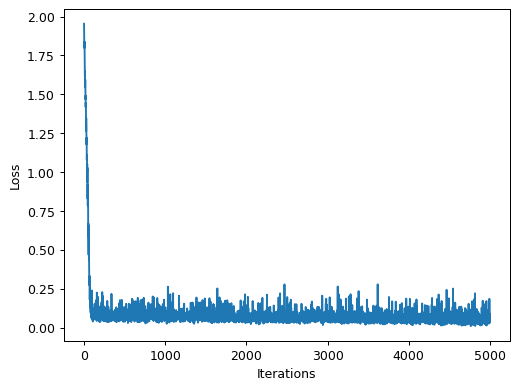

In [10]:
import matplotlib.pyplot as plt
plt.figure(dpi=90)
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

Evaluate the model performance after fine-tuning. You should see a much higher score compared to the previous results.

In [8]:
evaluate(model, squad_dataset, squad_metric)

  0%|          | 0/10570 [00:00<?, ?it/s]

{'exact_match': 0.03784295175023652, 'f1': 1.44936592002323}

Try the model using your own text and question. Can it give you the correct answer?

In [9]:
model('Your question', 'Your context')

'Your questionYour context'